In [1]:
import numpy as np #numerical computation
import pandas as pd #data wrangling
import matplotlib.pyplot as plt #plotting package
#Next line helps with rendering plots
%matplotlib inline
import matplotlib as mpl #add'l plotting functionality
import seaborn as sns #a fancy plotting package
mpl.rcParams['figure.dpi'] = 400 #high res figures

# Necessary steps from previous exercises in this chapter

Note: adjust the path in the following cell to the location where you saved the cleaned data from Chapter 1.

In [2]:
df = pd.read_csv('../Data/Chapter_1_cleaned_data.csv')

Subset column list to features as in Chapter 3

In [3]:
features_response = df.columns.tolist()

In [4]:
features_response[:5]

['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE']

In [5]:
features_response[-5:]

['EDUCATION_CAT', 'graduate school', 'high school', 'others', 'university']

In [6]:
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                   'PAY_6', 'EDUCATION_CAT', 'graduate school',
                   'high school', 'none','others', 'university']

In [7]:
features_response = [item for item in features_response
                     if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

Synthetic data from curve fit example

In [8]:
np.random.seed(seed=9)
n_points = 20
X = np.random.uniform(0, 11, n_points)
X = np.sort(X)
Y = (-X+2) * (X-9) + np.random.normal(0, 3, n_points)

In [9]:
lin_fit = np.polyfit(X, Y, 1)

Function to take in the polynomial coefficients and produce the y values

In [10]:
def poly_fun(X, p):
    Y = np.zeros_like(X)
    power = len(p)-1
    for coefficient in p:
        Y = Y + coefficient*X**power
        power = power - 1
    return Y

In [11]:
lin_fit

array([ 0.44464616, -0.61869372])

In [12]:
poly_fun(X,lin_fit)

array([-0.56795261, -0.42917123, -0.2075489 ,  0.03588094,  0.07638692,
        0.19702737,  0.45030033,  0.59479584,  1.07117738,  1.42827491,
        1.80618691,  1.83602902,  2.06083994,  2.18273629,  2.64318106,
        2.8007159 ,  2.81695454,  3.67843349,  3.77355591,  4.03257388])

For plotting the models over a more continuous range of values

In [13]:
curve_x = np.linspace(0,11,333)

In [14]:
cmap = mpl.cm.get_cmap('tab10')

From Exercise 17

In [15]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [16]:
X_synthetic, y_synthetic = \
make_classification(n_samples=1000, n_features=200, n_informative=3, n_redundant=10,
                    n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None,
                    flip_y=0.01, class_sep=0.8, hypercube=True, shift=0.0, scale=1.0,
                    shuffle=True, random_state=24)

In [17]:
print(X_synthetic.shape, y_synthetic.shape)
print(np.mean(y_synthetic))

(1000, 200) (1000,)
0.501


In [18]:
X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(
X_synthetic, y_synthetic,
test_size=0.2, random_state=24)

In [19]:
lr_syn = \
LogisticRegression(solver='liblinear', penalty='l1', C=1000, random_state=1)

# Lasso (L1) and Ridge (L2) Regularization

Create arrays of polynomial features for training and plotting

In [20]:
poly_features = X.reshape(20,-1)
plot_features = curve_x.reshape(333,-1)
for power in range (2,16):
    power_array = X.reshape(20,-1)**power
    poly_features = np.append(poly_features, power_array.reshape(20,-1), axis=1)
    plot_power_array = curve_x.reshape(333,-1)**power
    plot_features = np.append(plot_features, plot_power_array.reshape(333,-1), axis=1)

Fit a linear regression with ridge penalty. Feature scaling is performed by the regression function.

In [21]:
from sklearn.linear_model import Ridge

In [22]:
regressor = Ridge(alpha=0.001, fit_intercept=True, normalize=True,
                        copy_X=True, max_iter=None, tol=0.001,
                        random_state=1)

In [23]:
regressor.fit(poly_features, Y)

Ridge(alpha=0.001, normalize=True, random_state=1)

In [24]:
Y_pred = regressor.predict(plot_features)

(-20.0, 20.0)

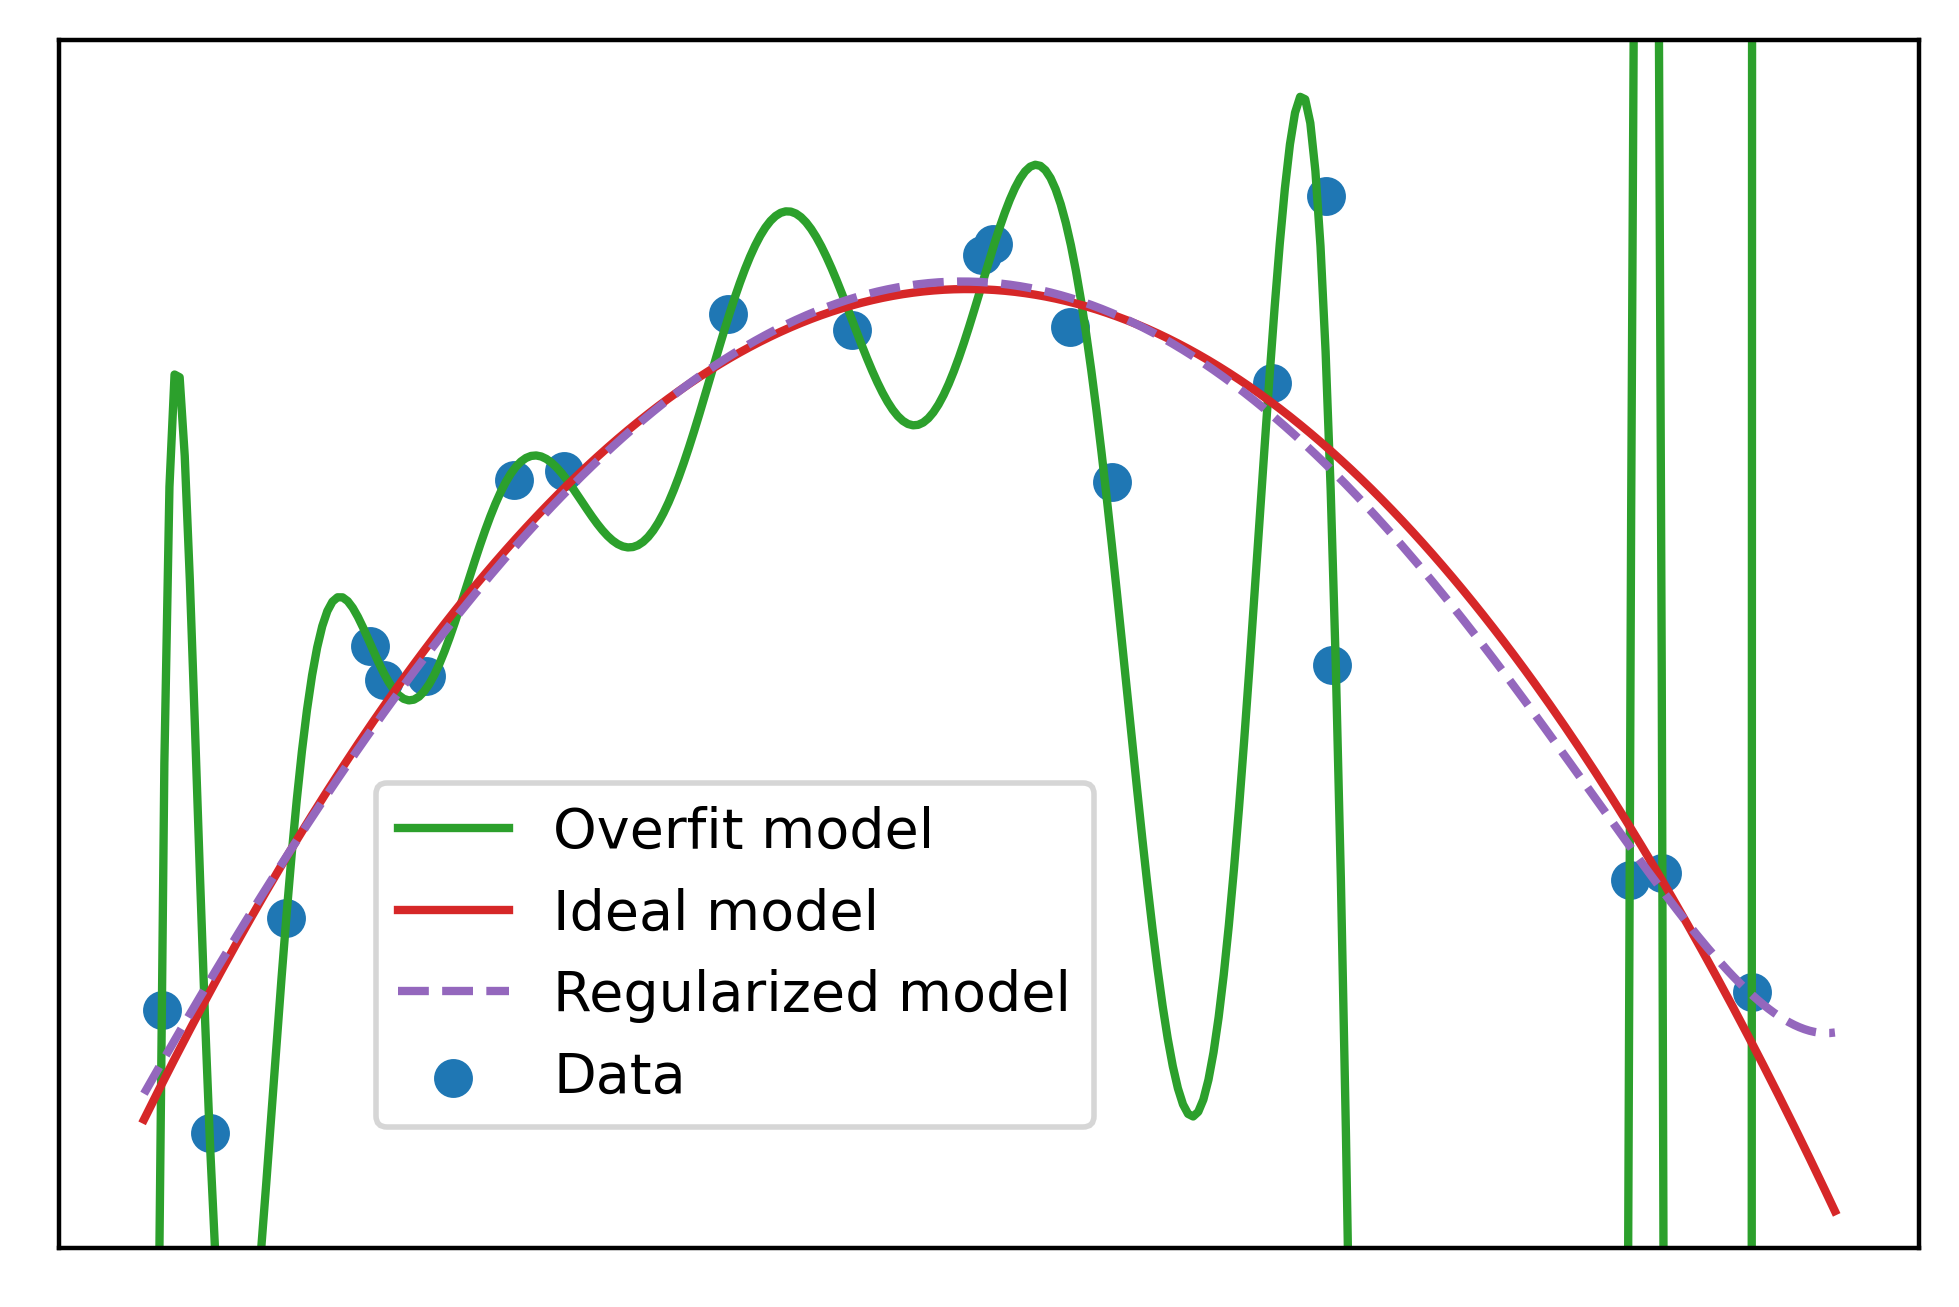

In [25]:
plt.scatter(X, Y, label='Data', color=cmap(0))
plt.plot(curve_x, poly_fun(curve_x,np.polyfit(X, Y, 15)), label='Overfit model', color=cmap(2))
plt.plot(curve_x, poly_fun(curve_x,np.polyfit(X, Y, 2)), label='Ideal model', color=cmap(3))
plt.plot(curve_x, Y_pred, label='Regularized model', color=cmap(4), linestyle='--')
plt.legend(loc=[0.17, 0.1])
plt.xticks([])
plt.yticks([])
plt.ylim([-20, 20])


# Cross Validation: Choosing the Regularization Parameter and Other Hyperparameters

In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

In [27]:
n_folds = 4

Note for `StratifiedKFold`, `shuffle=False` by default, the opposite behavior of `train_test_split` which we have been using.

In [28]:
k_folds = KFold(n_splits=n_folds, shuffle=False)

In [29]:
def plot_kfolds(k_folds_iterator):
    fold_counter = 0
    for train_index, test_index in k_folds_iterator.split(X_syn_train, y_syn_train):

        #Axis to hold the plot of this fold
        ax = plt.subplot(n_folds,1,fold_counter+1)

        #Background rectangle representing all samples
        n_train_samples = len(y_syn_train)
        rect = mpl.patches.Rectangle(xy=(0,0), width=n_train_samples, height=1)
        ax.add_patch(rect)

        #Plot each testing sample from this fold as a vertical line
        for this_text_ix in test_index:
            ax.plot([this_text_ix, this_text_ix], [0, 1], color=cmap(1),
                    linewidth=0.75)

        #Plot formatting
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(0, n_train_samples)
        ax.set_ylim(0,1)
        
        #Subplot titles
        if fold_counter == 0:
            ax.text(0.26, 1.2, 'Training data,',
                    transform=ax.transAxes, backgroundcolor = cmap(0))
            ax.text(0.45, 1.2, 'testing data:',
                    transform=ax.transAxes, backgroundcolor = cmap(1))
            ax.text(0.62, 1.2, 'fold {}'.format(fold_counter+1), transform=ax.transAxes)
        else:
            ax.text(0.45, 1.2, 'Fold {}'.format(fold_counter+1), transform=ax.transAxes)

        fold_counter += 1

    plt.tight_layout()

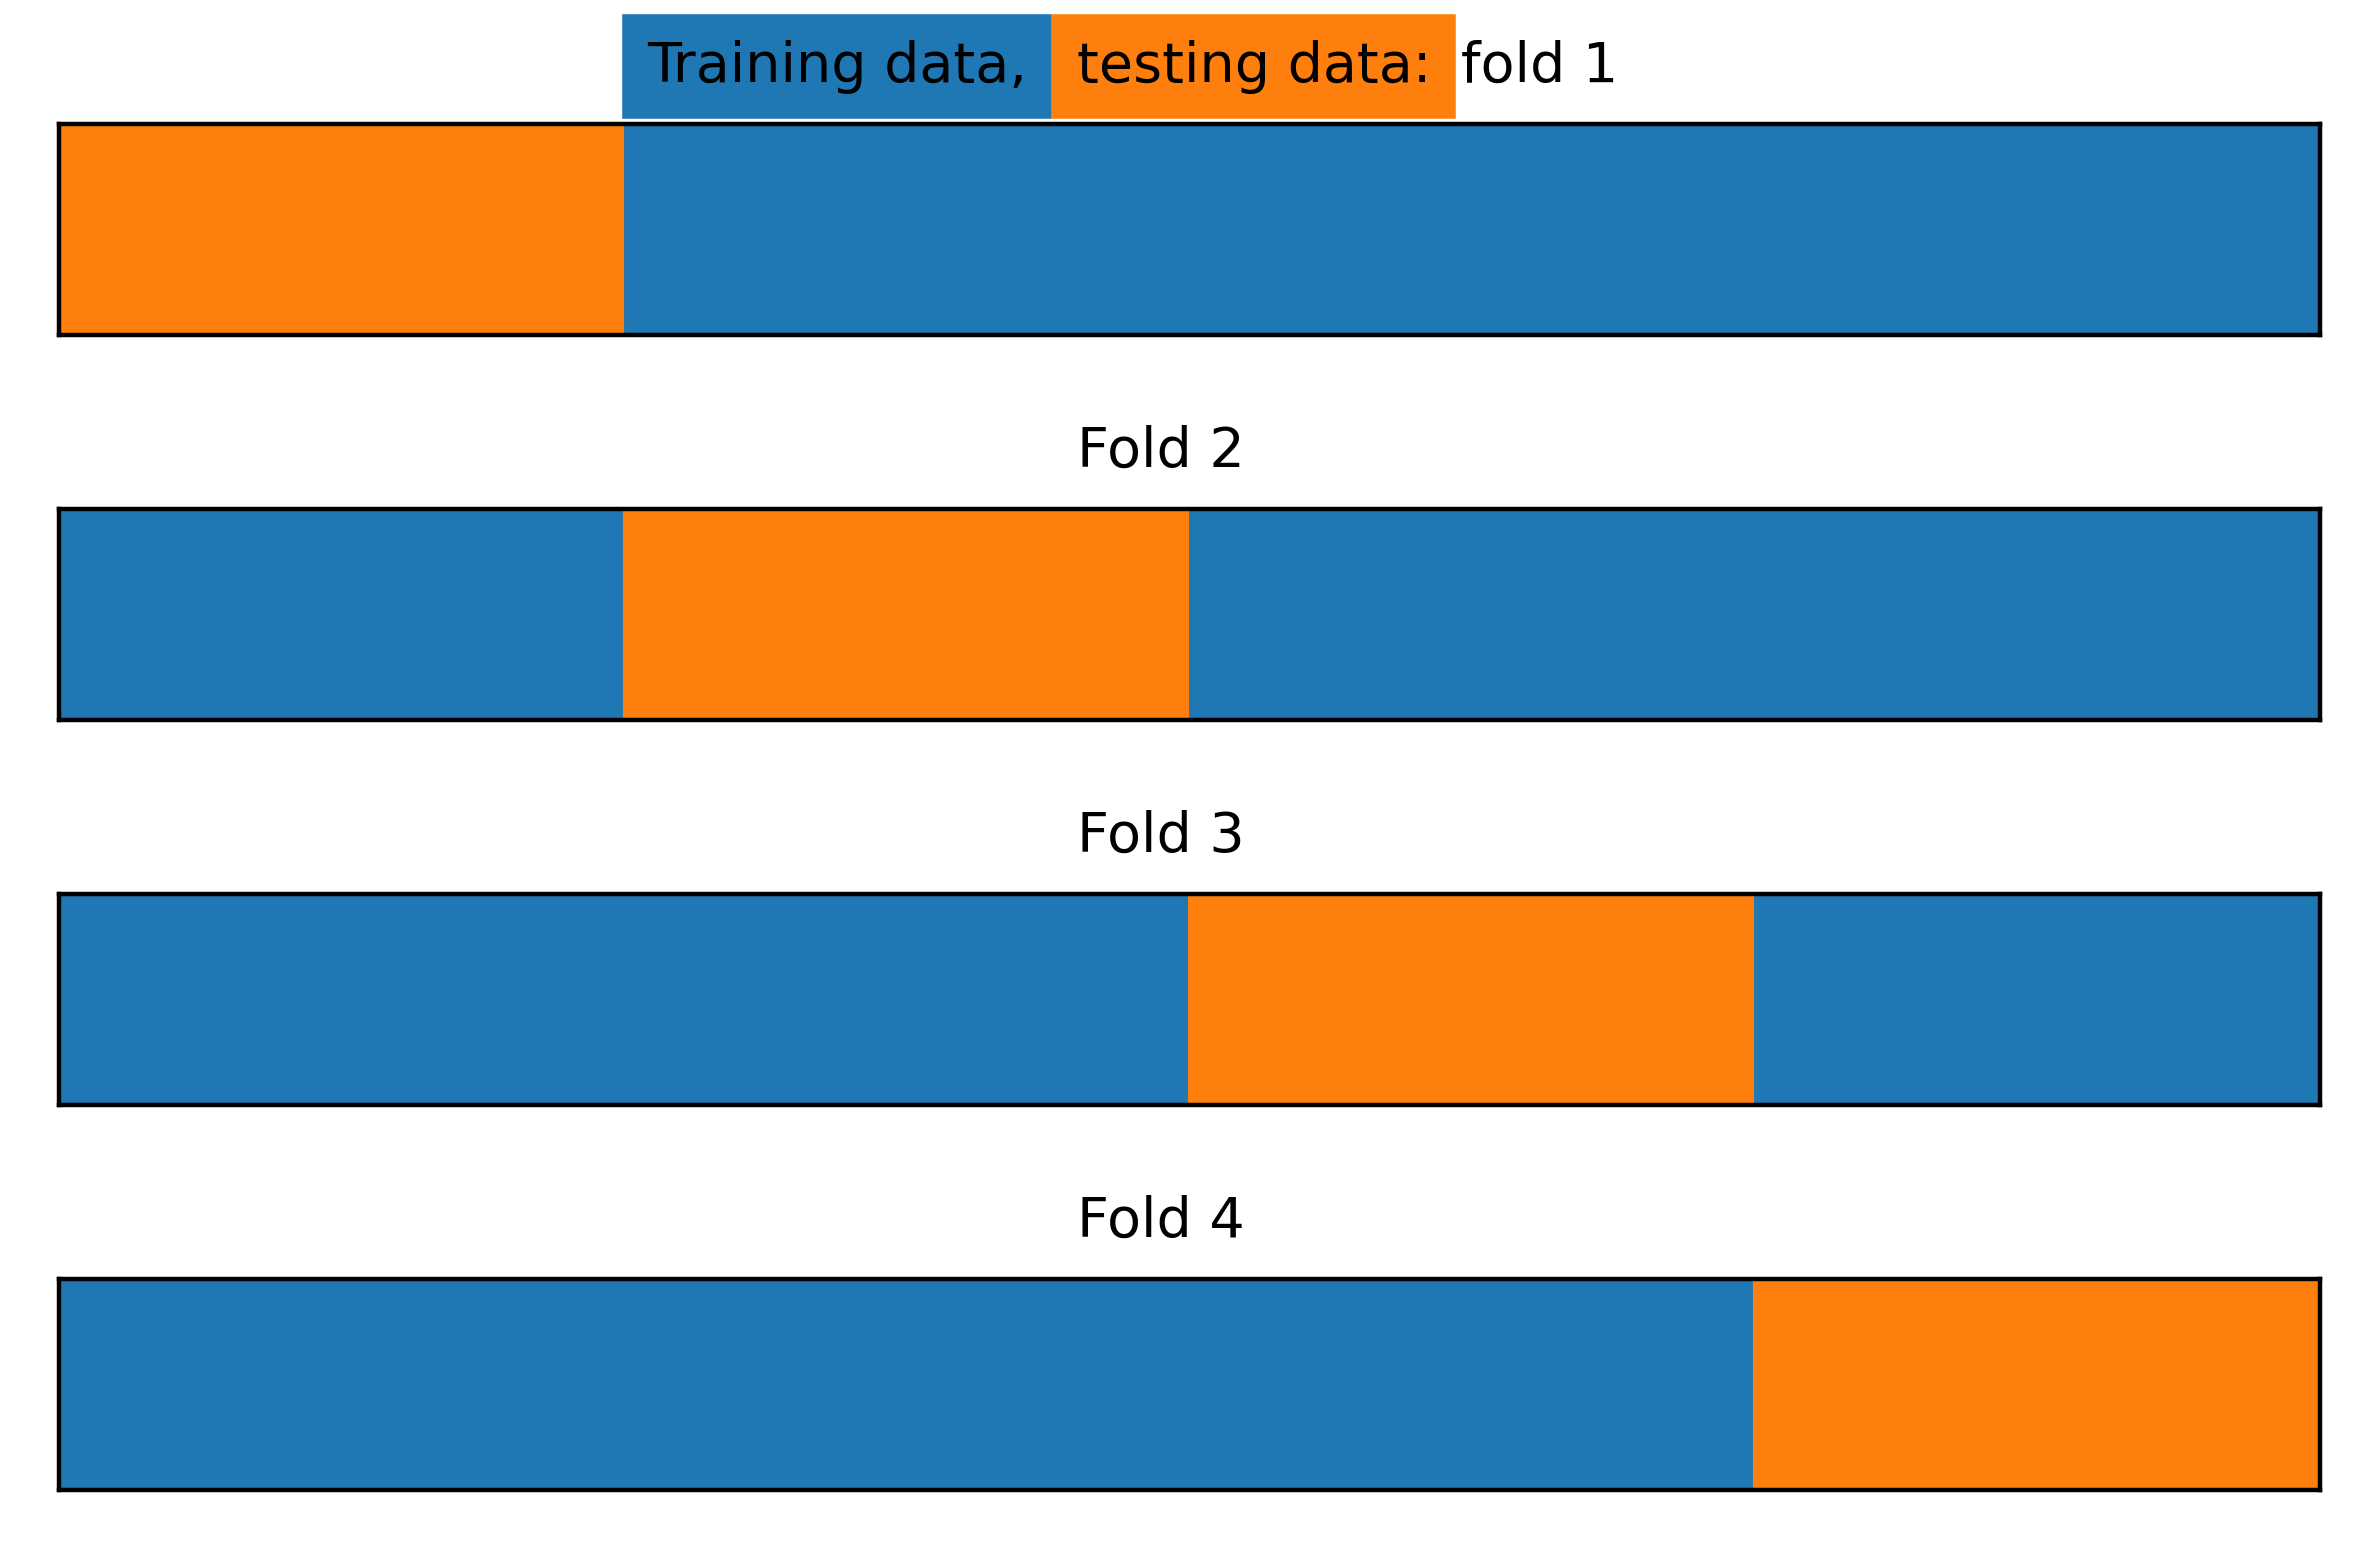

In [30]:
plot_kfolds(k_folds)

In [31]:
k_folds = StratifiedKFold(n_splits=n_folds, shuffle=False)

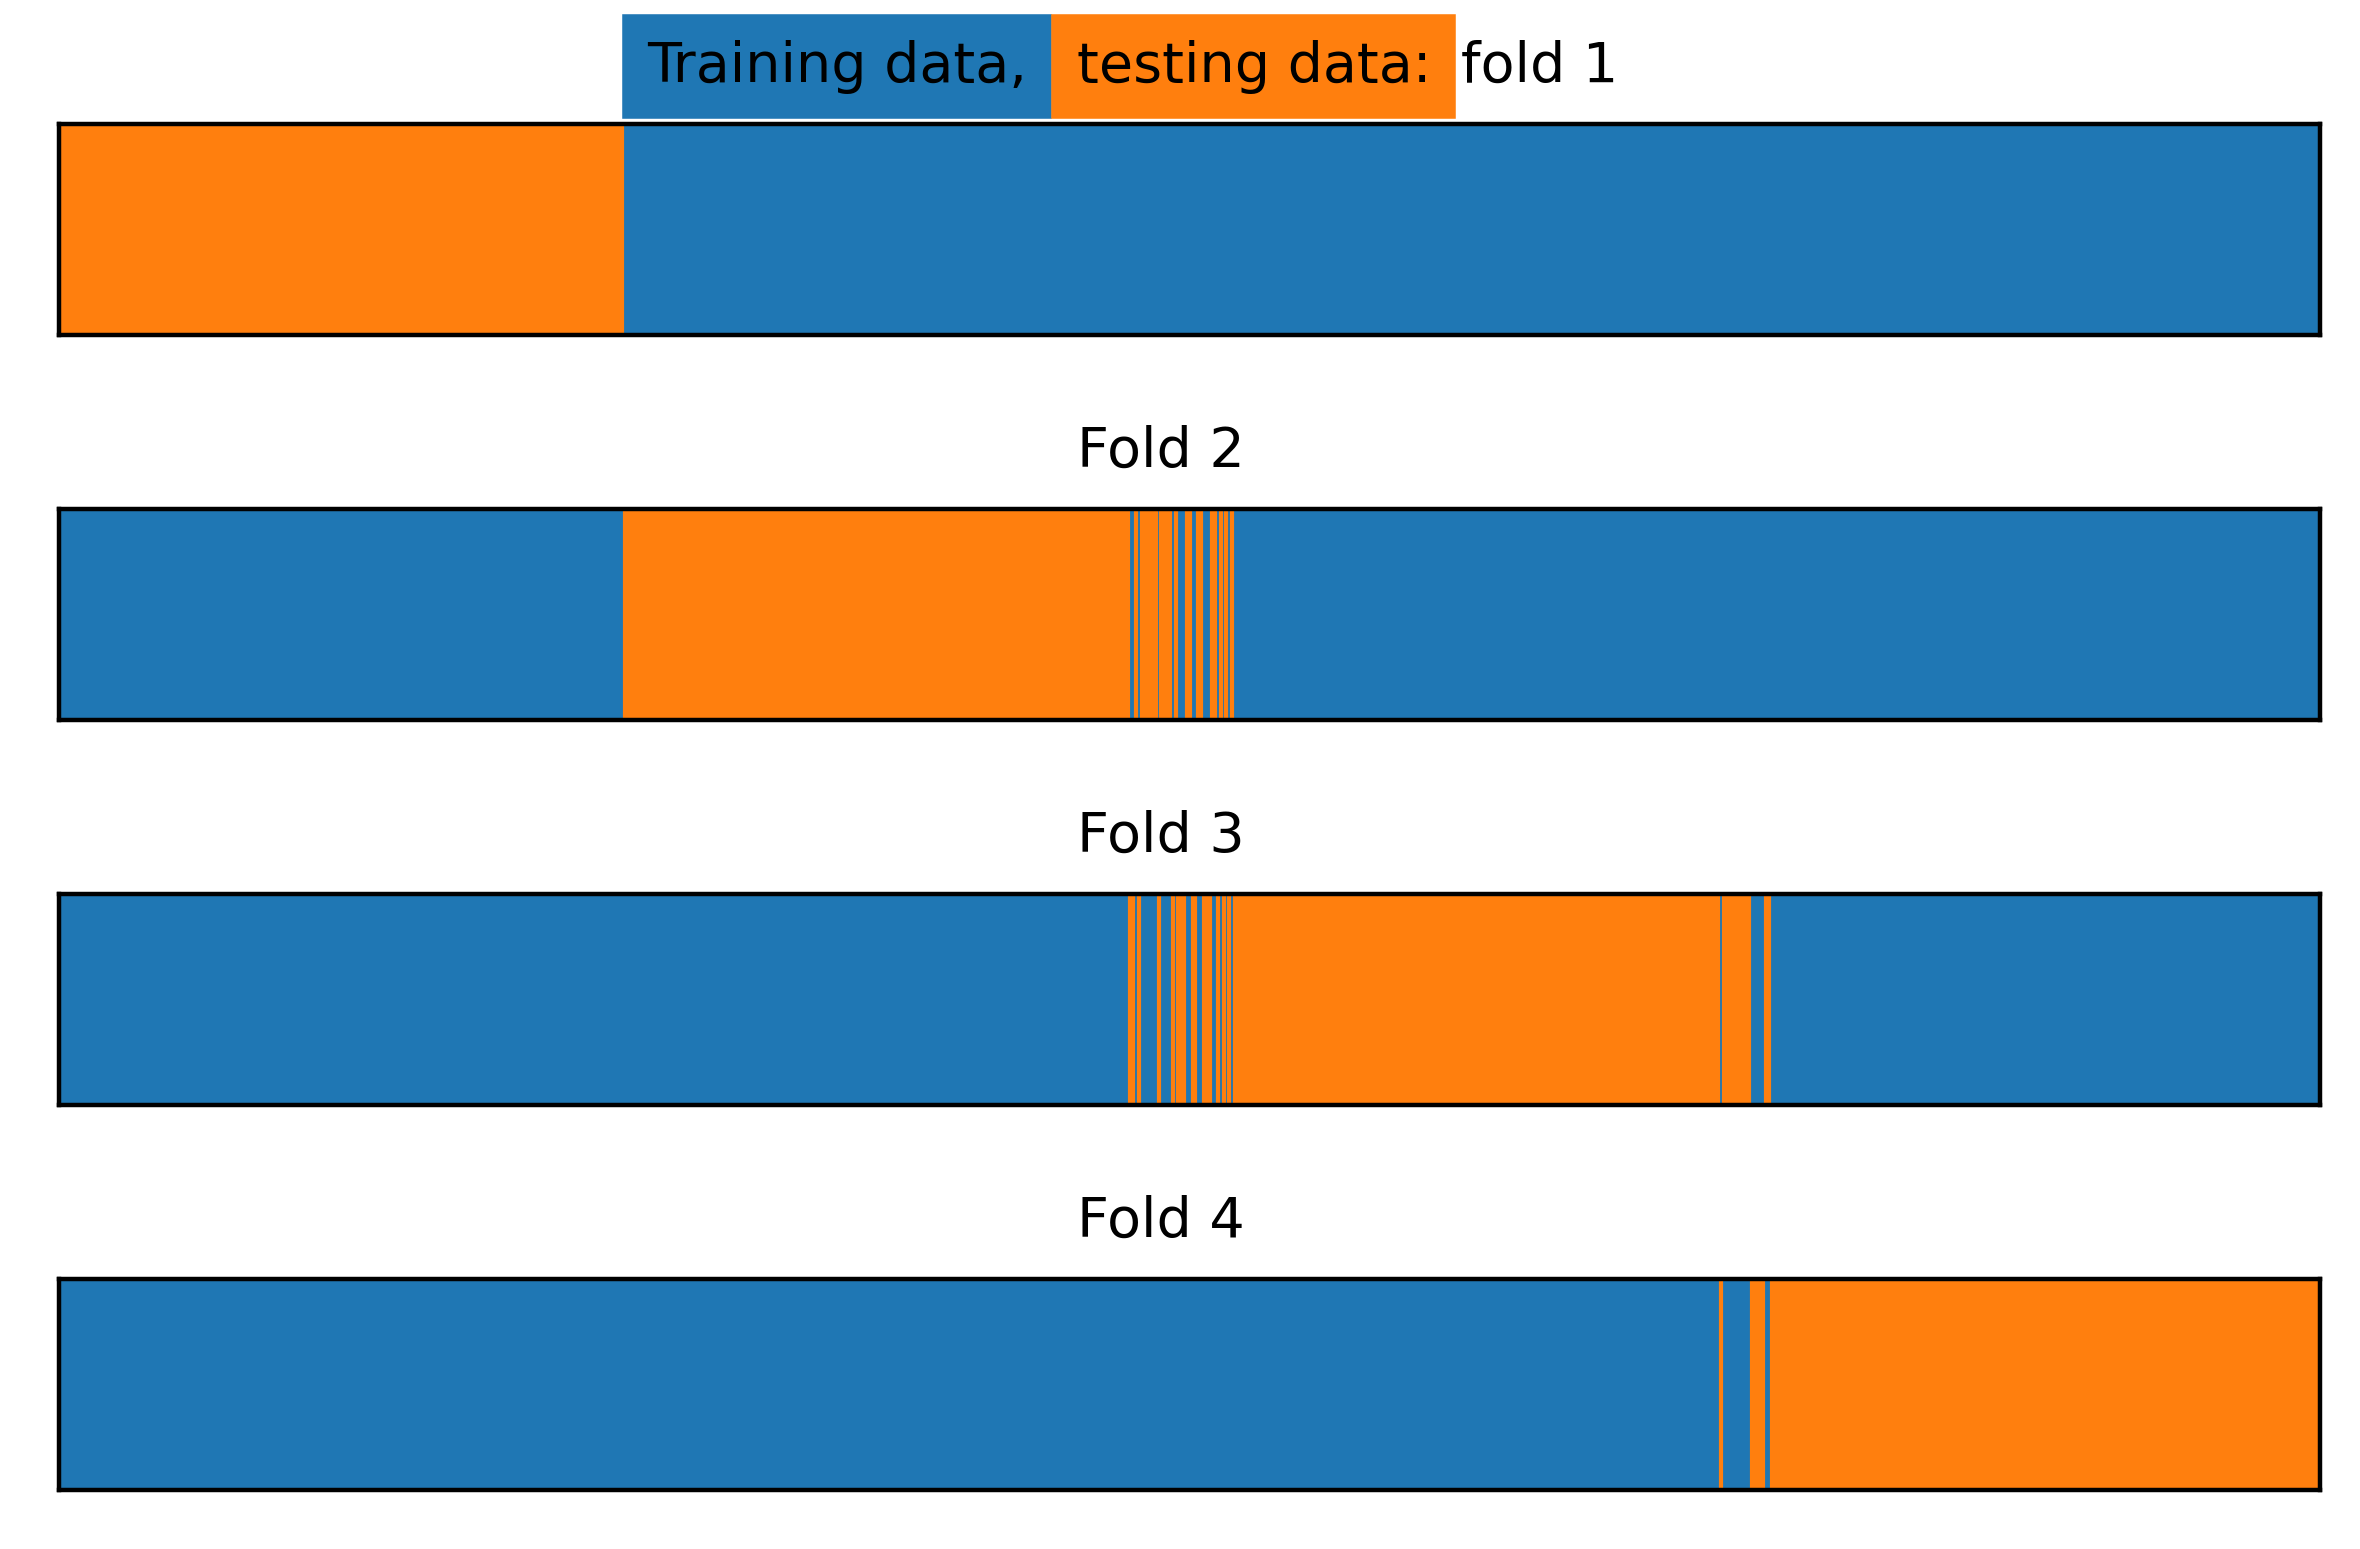

In [32]:
plot_kfolds(k_folds)

In [33]:
k_folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1)

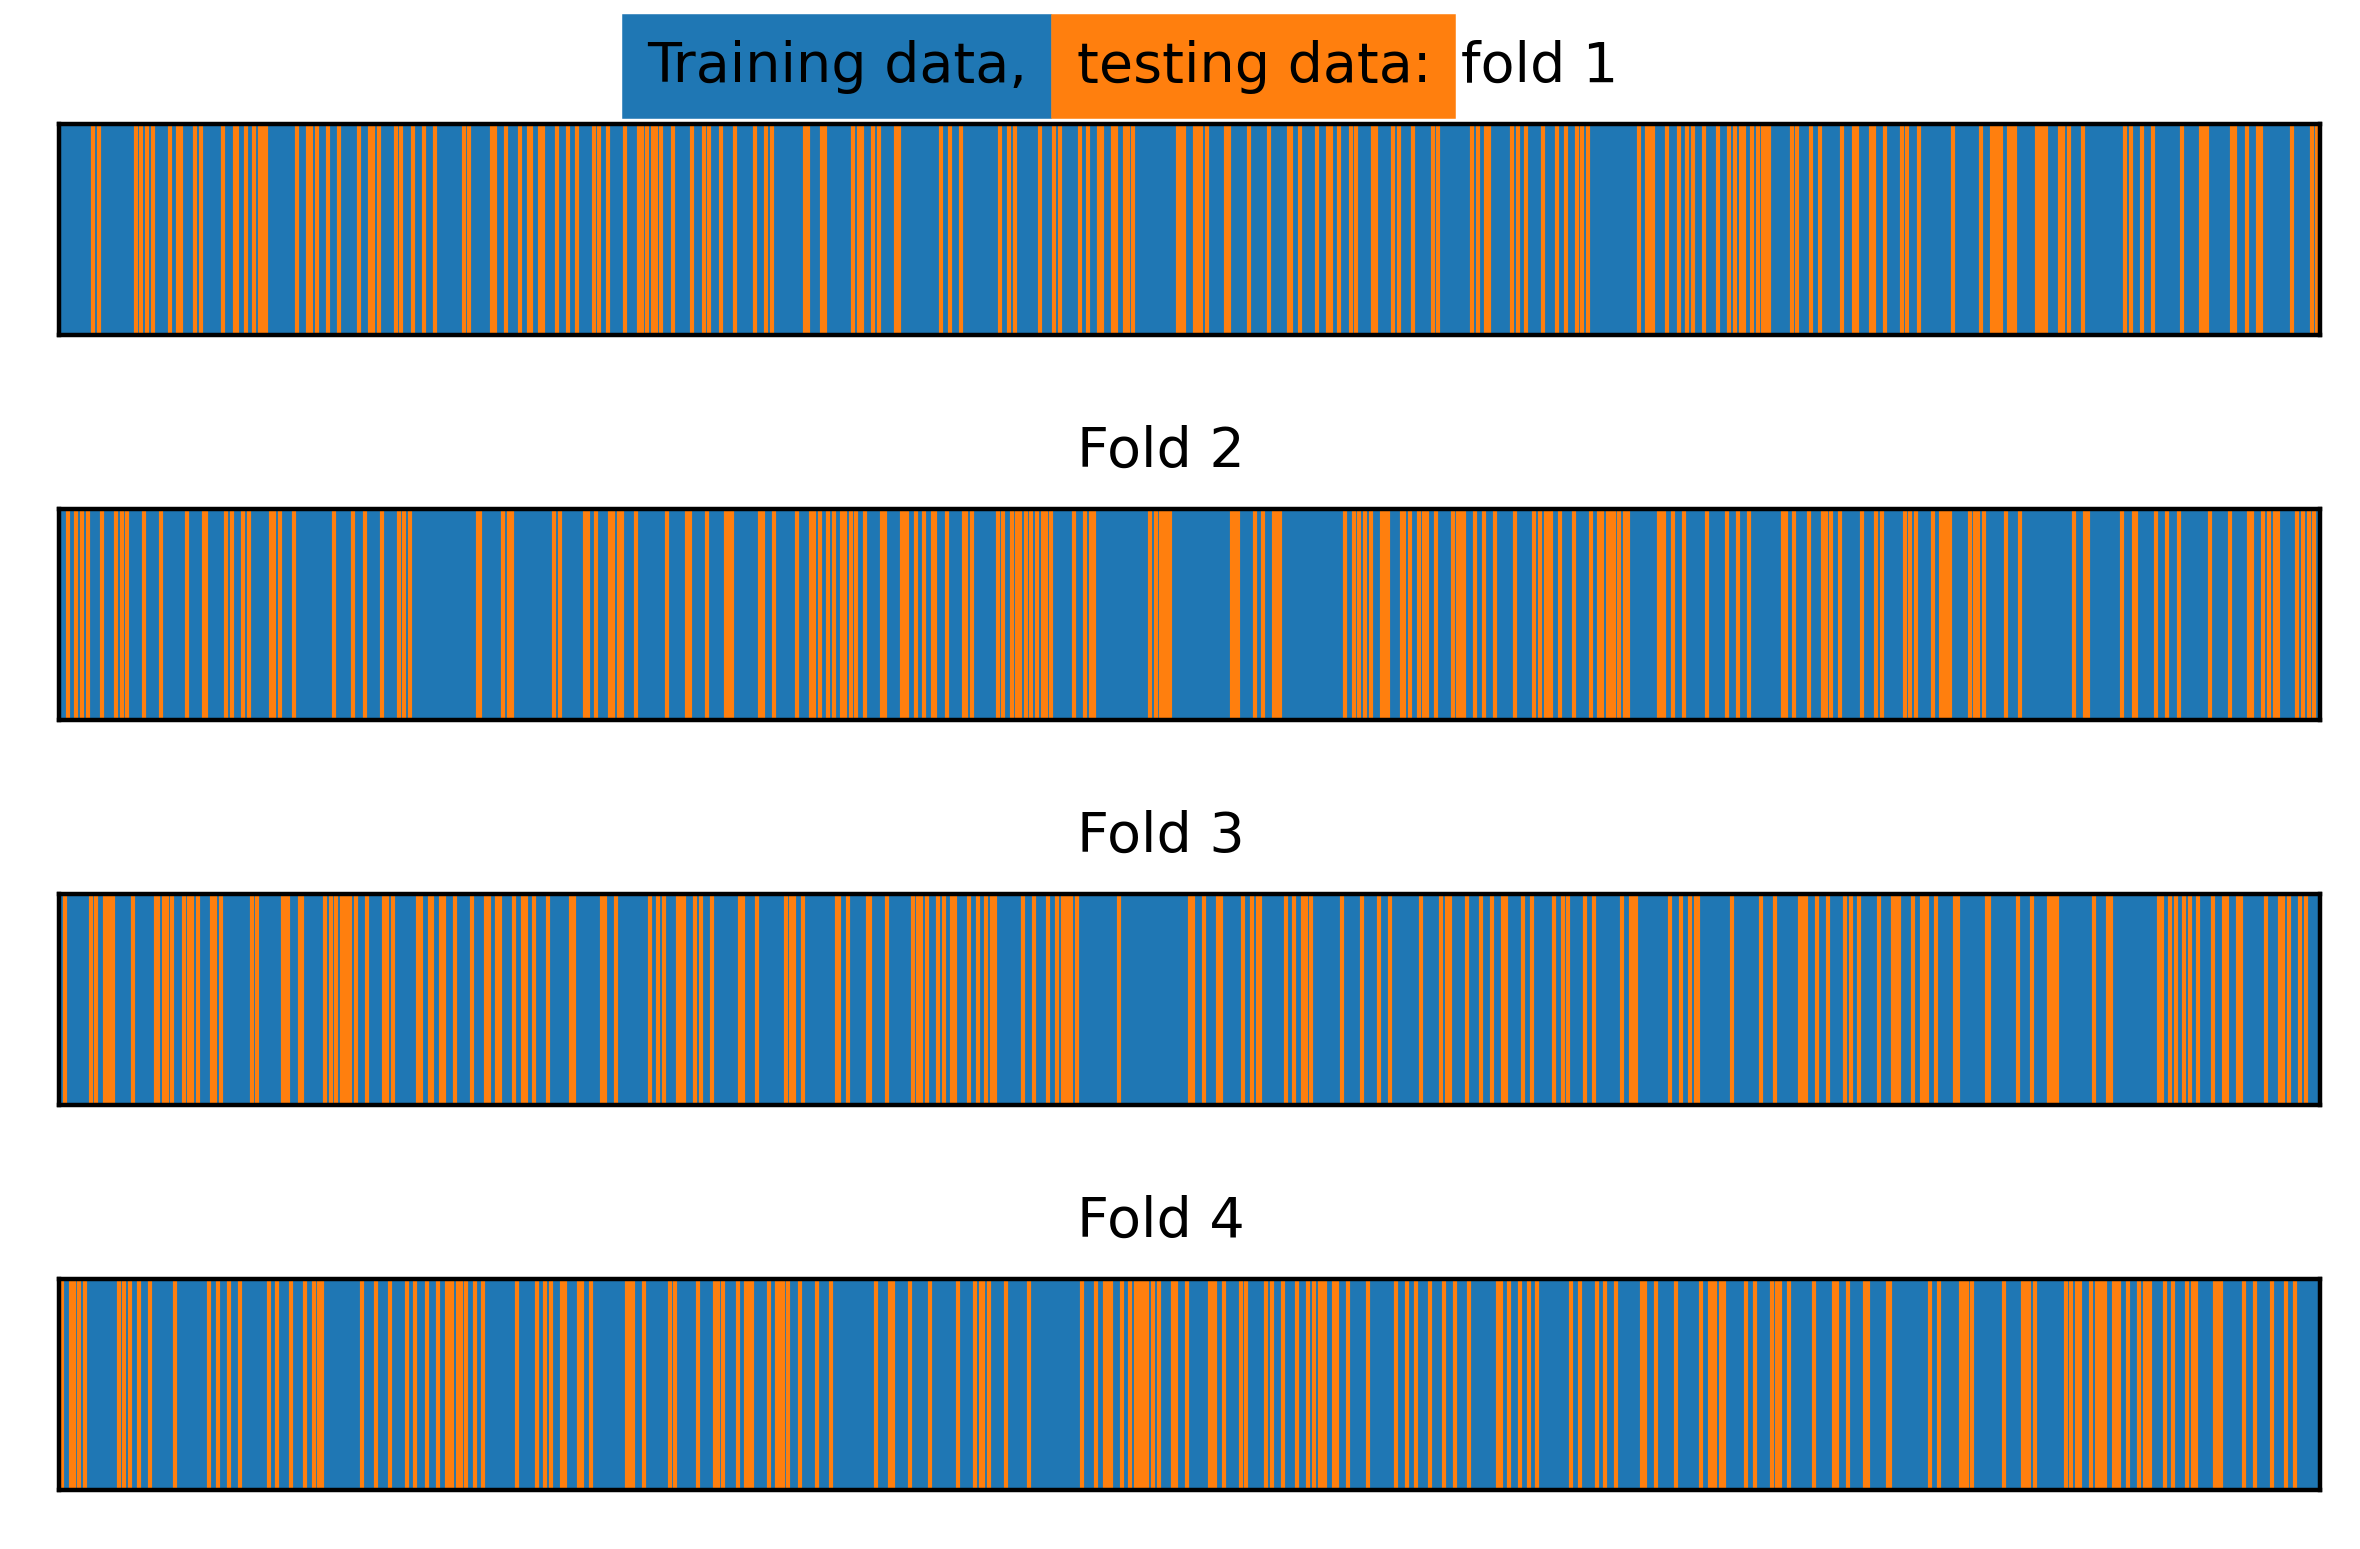

In [34]:
plot_kfolds(k_folds)

# Exercise 18: Reducing Overfitting on the Synthetic Data Classification Problem

In [35]:
C_val_exponents = np.linspace(3,-3,13)
C_val_exponents

array([ 3. ,  2.5,  2. ,  1.5,  1. ,  0.5,  0. , -0.5, -1. , -1.5, -2. ,
       -2.5, -3. ])

In [36]:
C_vals = np.float(10)**C_val_exponents
C_vals

array([1.00000000e+03, 3.16227766e+02, 1.00000000e+02, 3.16227766e+01,
       1.00000000e+01, 3.16227766e+00, 1.00000000e+00, 3.16227766e-01,
       1.00000000e-01, 3.16227766e-02, 1.00000000e-02, 3.16227766e-03,
       1.00000000e-03])

In [37]:
from sklearn.metrics import roc_curve

In [38]:
def cross_val_C_search(k_folds, C_vals, model, X, Y):
    
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc = [[]]*len(C_vals)

    for c_val_counter in range(len(C_vals)):
        #Set the C value for the model object
        model.C = C_vals[c_val_counter]
        #Count folds for each value of C
        fold_counter = 0
        #Get training and testing indices for each fold
        for train_index, test_index in k_folds.split(X, Y):
            #Subset the features and response, for training and testing data for
            #this fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]

            #Fit the model on the training data
            model.fit(X_cv_train, y_cv_train)

            #Get the training ROC AUC
            y_cv_train_predict_proba = model.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])

            #Get the testing ROC AUC
            y_cv_test_predict_proba = model.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])

            #Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)

            #Increment the fold counter
            fold_counter += 1

        #Indicate progress
        print('Done with C = {}'.format(lr_syn.C))

    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

In [39]:
%%time
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = \
cross_val_C_search(k_folds, C_vals, lr_syn, X_syn_train, y_syn_train)

Done with C = 1000.0
Done with C = 316.22776601683796
Done with C = 100.0
Done with C = 31.622776601683793
Done with C = 10.0
Done with C = 3.1622776601683795
Done with C = 1.0
Done with C = 0.31622776601683794
Done with C = 0.1
Done with C = 0.03162277660168379
Done with C = 0.01
Done with C = 0.0031622776601683794
Done with C = 0.001
CPU times: user 18.2 s, sys: 102 ms, total: 18.3 s
Wall time: 13.8 s


Text(0.5, 1.0, 'Cross validation scores for each fold')

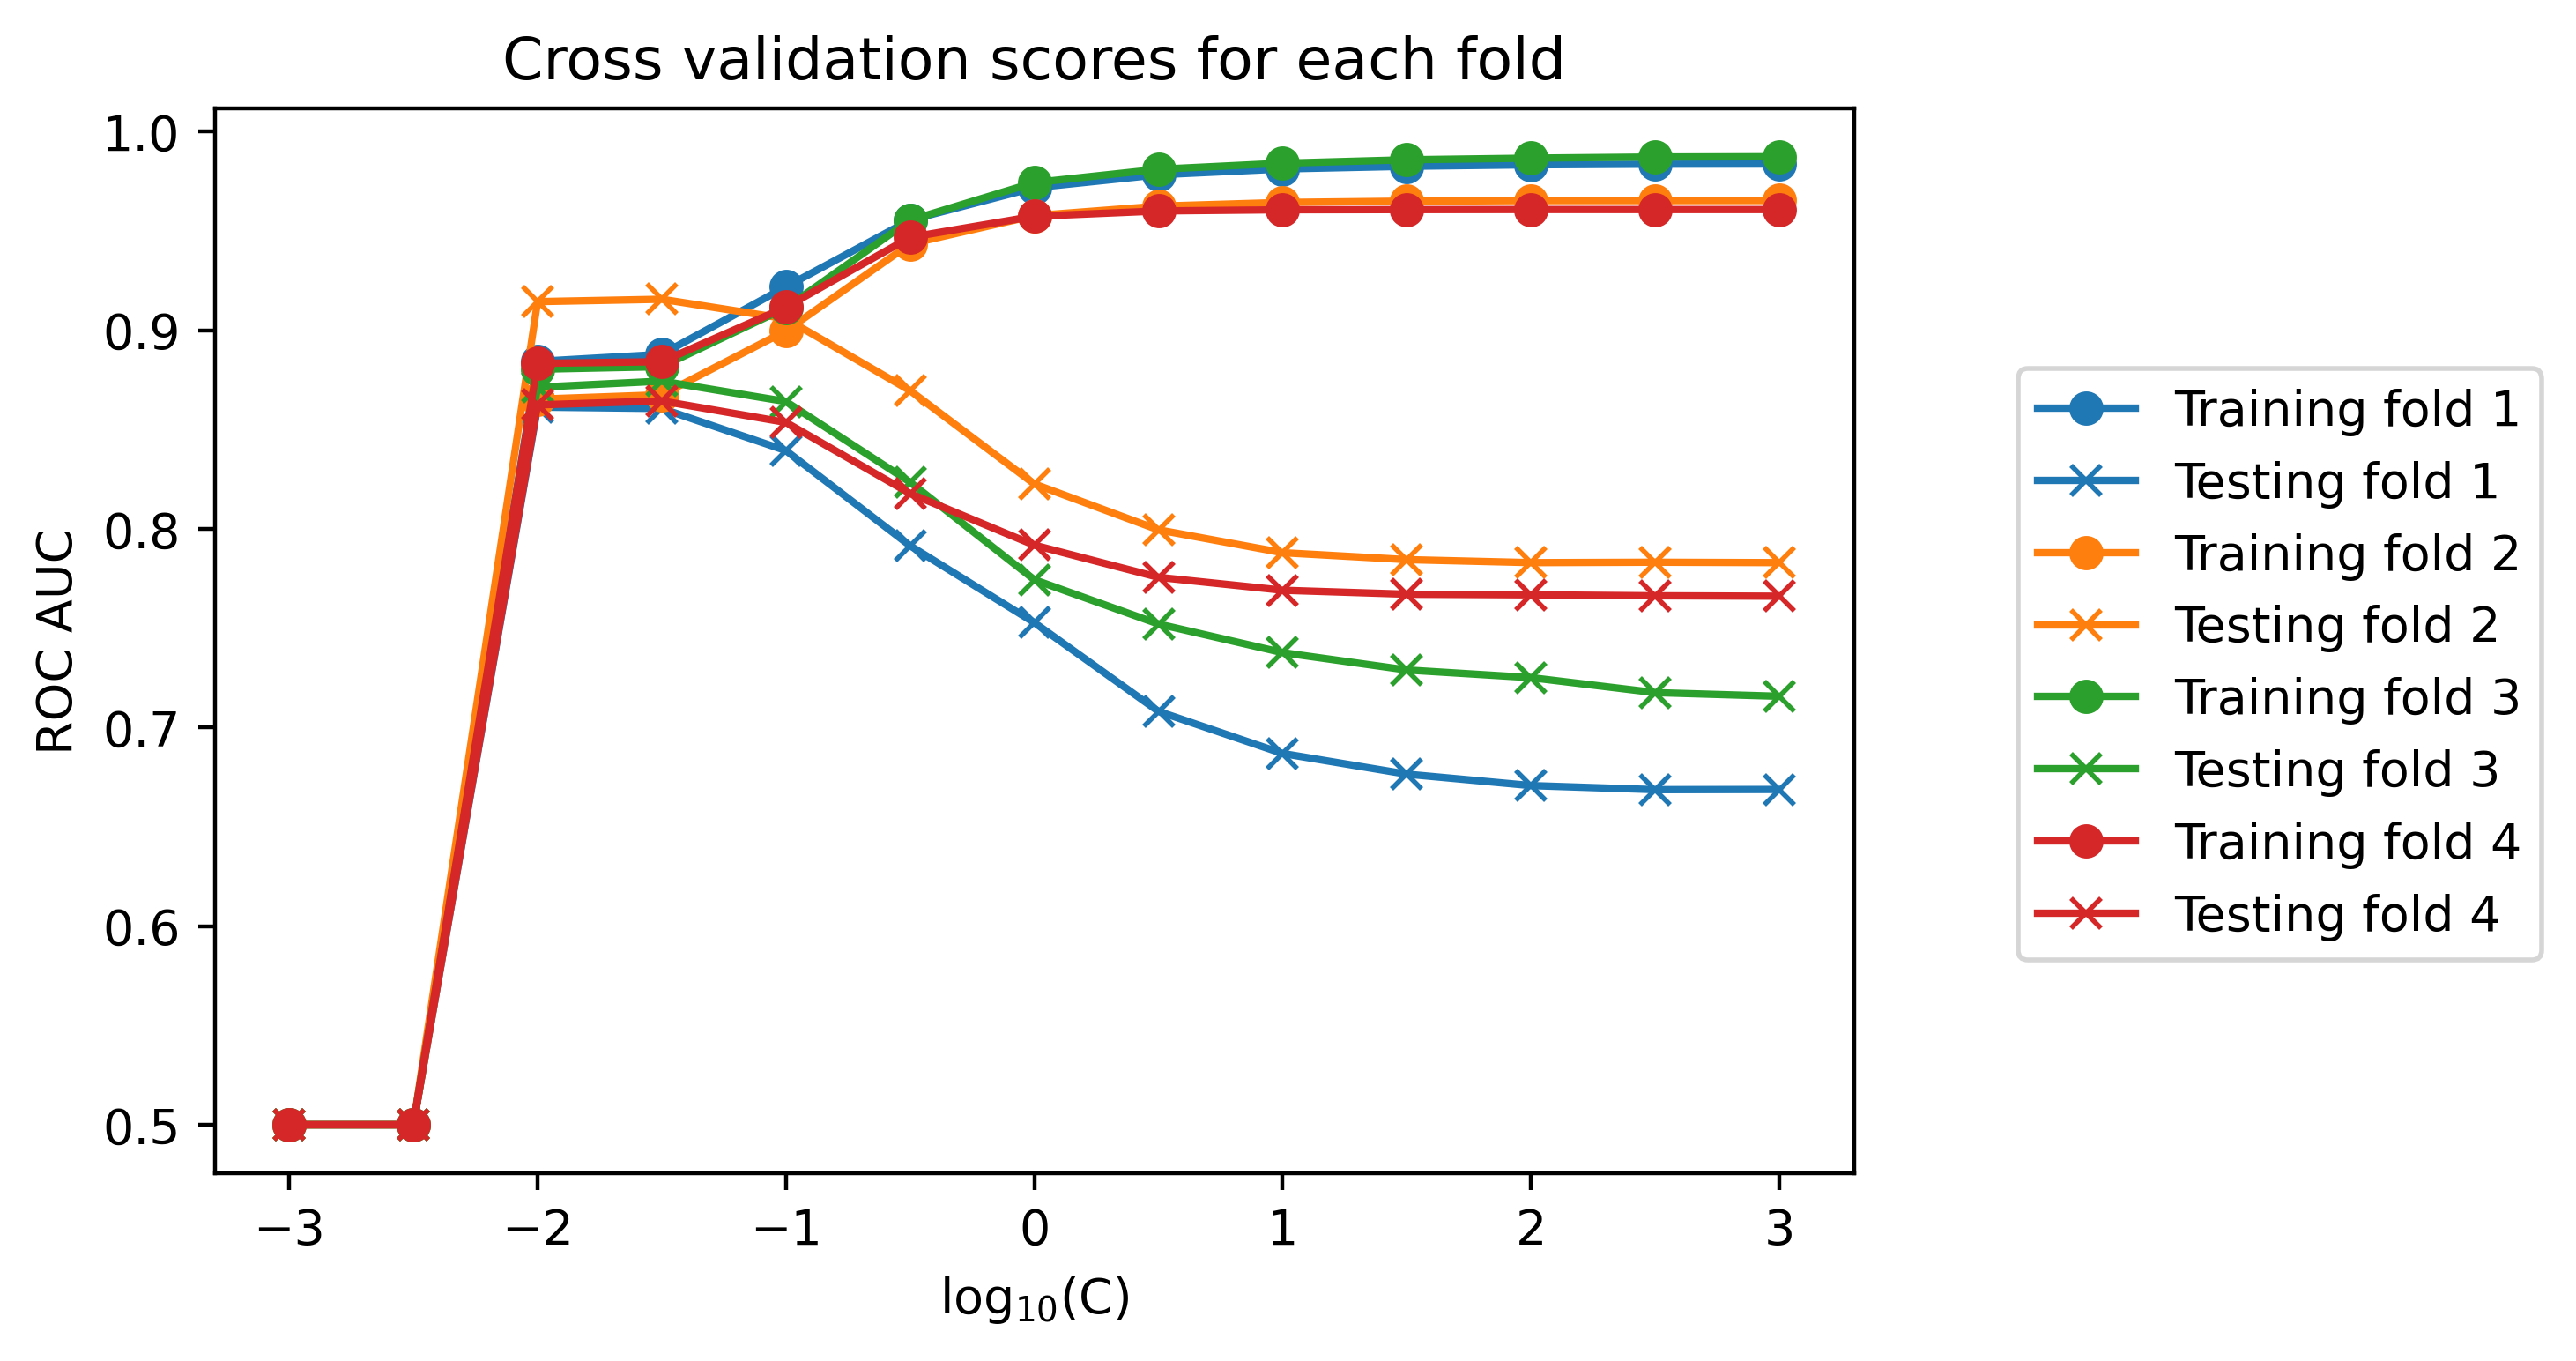

In [40]:
for this_fold in range(k_folds.n_splits):
    plt.plot(C_val_exponents, cv_train_roc_auc[this_fold], '-o',
             color=cmap(this_fold),
             label='Training fold {}'.format(this_fold+1))
    plt.plot(C_val_exponents, cv_test_roc_auc[this_fold], '-x',
             color=cmap(this_fold),
             label='Testing fold {}'.format(this_fold+1))
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend(loc = [1.1, 0.2])
plt.title('Cross validation scores for each fold')

In [41]:
np.mean(cv_test_roc_auc,0)

array([0.7334   , 0.7339375, 0.7364125, 0.7392625, 0.745425 , 0.758825 ,
       0.7854   , 0.8256   , 0.865725 , 0.87875  , 0.87735  , 0.5      ,
       0.5      ])

In [42]:
np.mean(cv_train_roc_auc,0)

array([0.97426389, 0.97420278, 0.97398611, 0.97351111, 0.97255556,
       0.97044444, 0.96528056, 0.95026111, 0.91108611, 0.88029722,
       0.87831667, 0.5       , 0.5       ])

In [43]:
cv_train_roc_auc.shape

(4, 13)

Text(0.5, 1.0, 'Cross validation scores averaged over all folds')

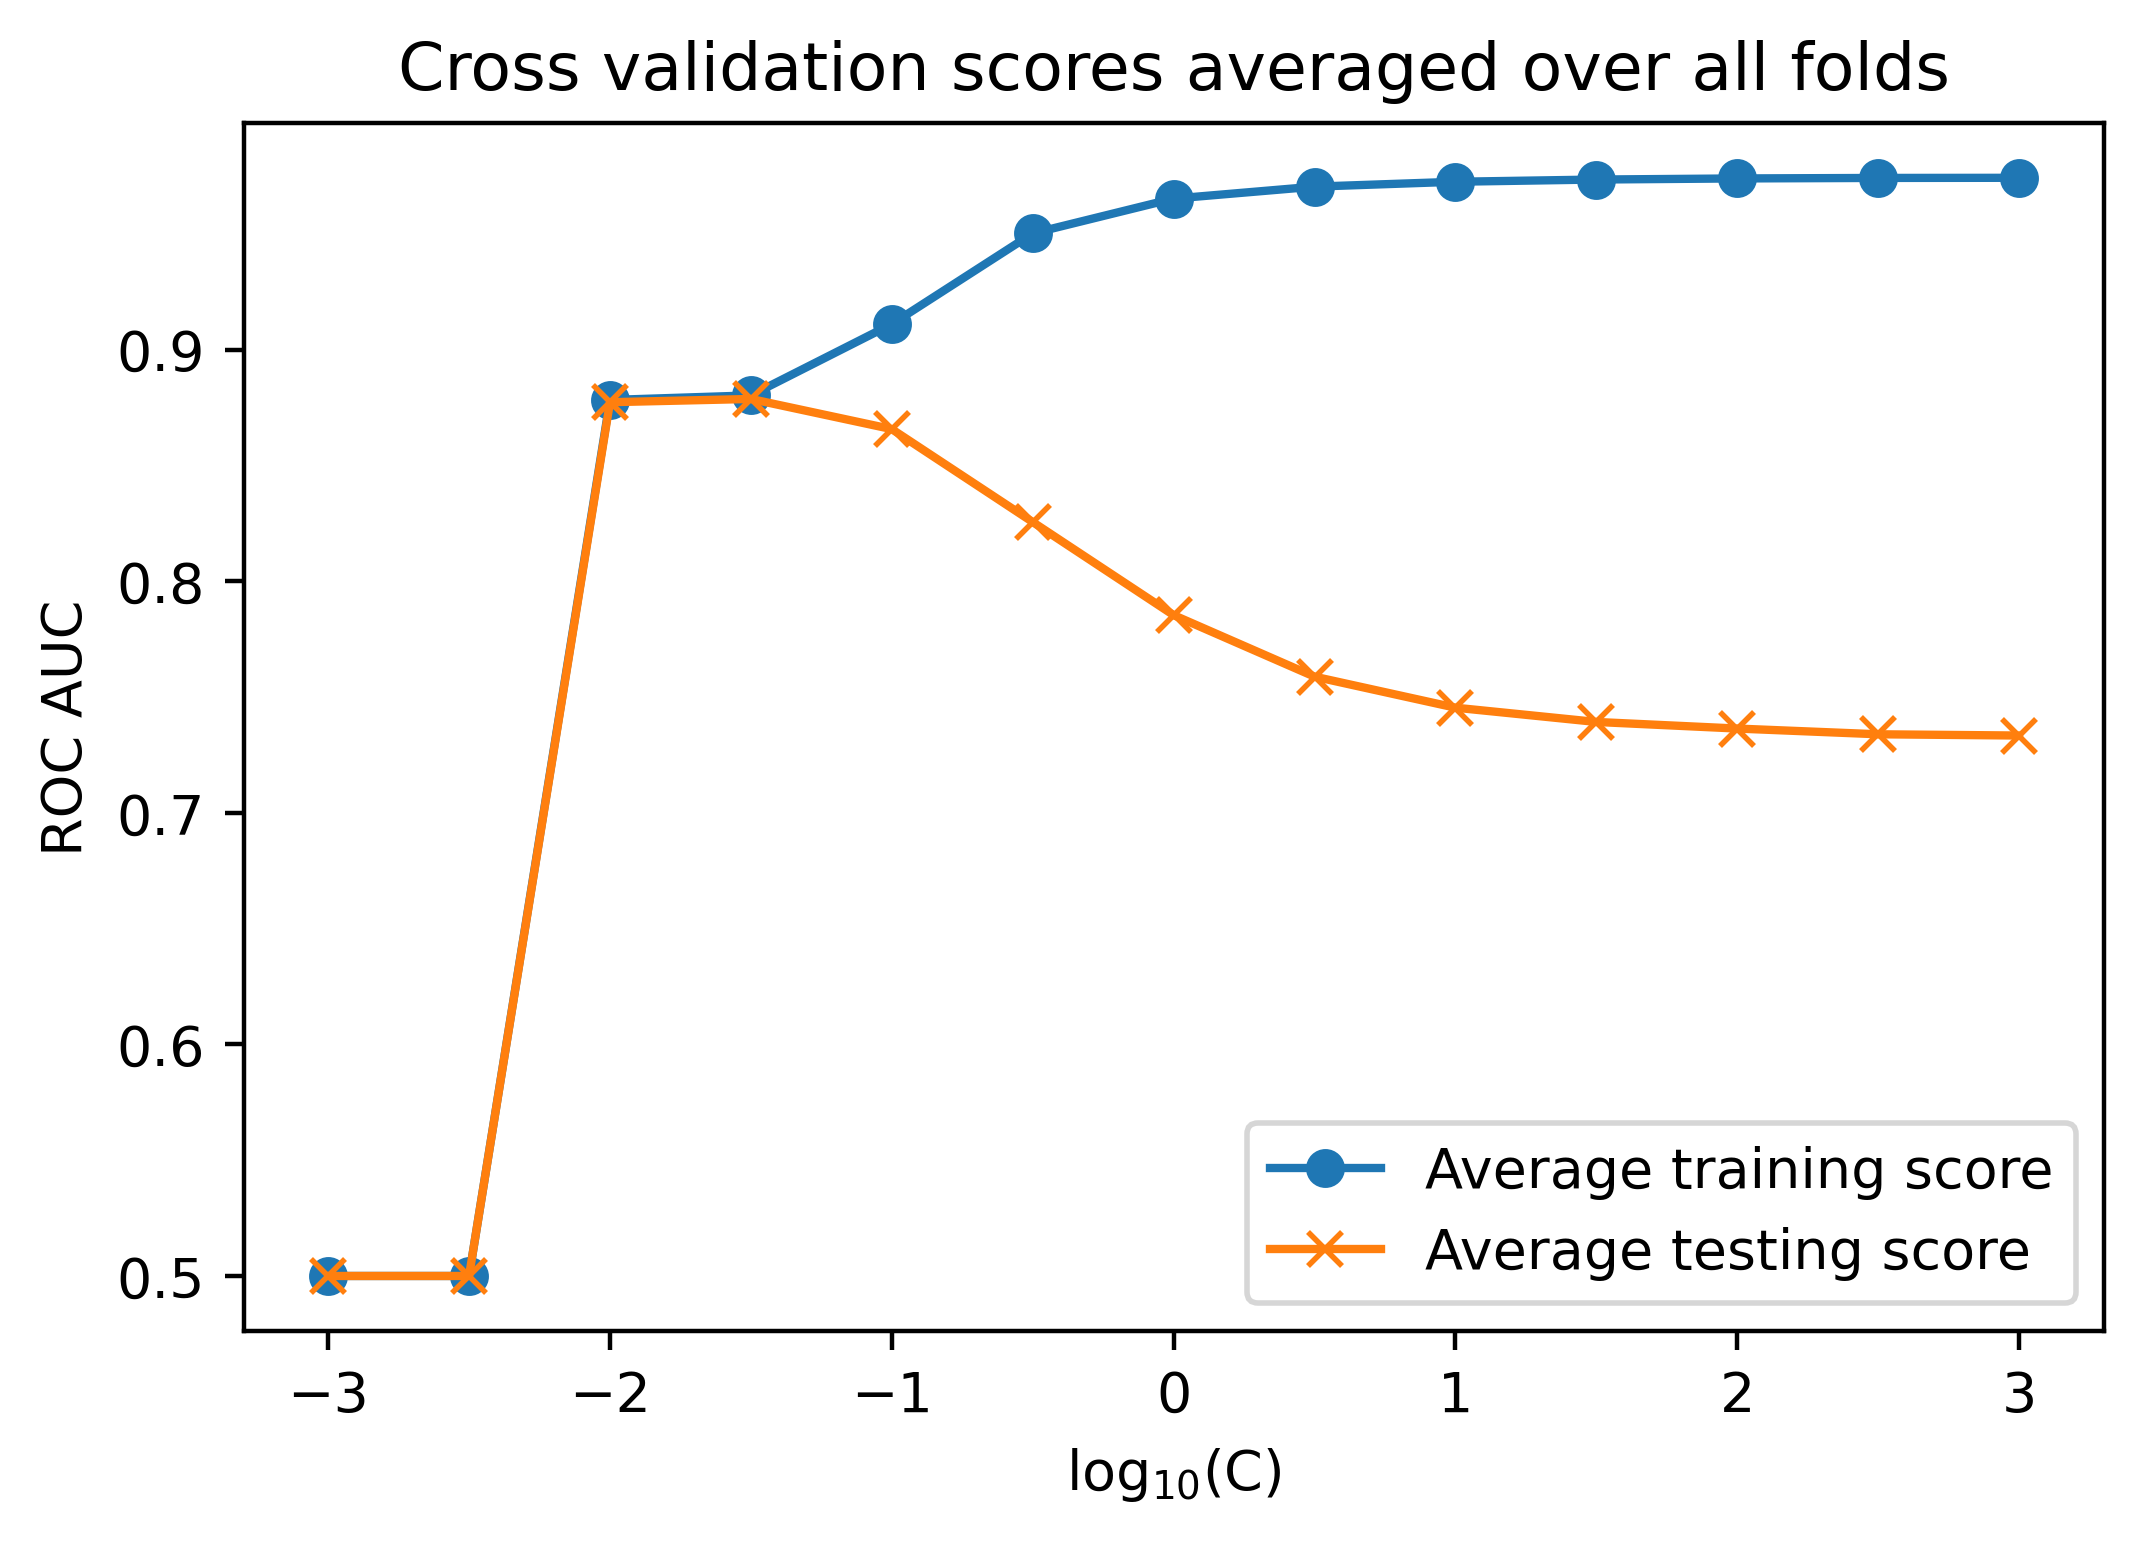

In [44]:
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation scores averaged over all folds')

The FPRs, TPRs, and thresholds for each fold, for each C value, are contained in the list of lists as tuples:

In [45]:
type(cv_test_roc[9][0])

tuple

In [46]:
#Some FPRs
cv_test_roc[9][0][0]

array([0.  , 0.04, 0.04, 0.06, 0.06, 0.07, 0.07, 0.1 , 0.1 , 0.11, 0.11,
       0.12, 0.12, 0.13, 0.13, 0.14, 0.14, 0.15, 0.15, 0.16, 0.16, 0.17,
       0.17, 0.18, 0.18, 0.19, 0.19, 0.21, 0.21, 0.22, 0.22, 0.24, 0.24,
       0.26, 0.26, 0.3 , 0.3 , 0.31, 0.31, 0.33, 0.33, 0.35, 0.35, 0.37,
       0.37, 0.39, 0.39, 0.41, 0.41, 0.42, 0.42, 0.43, 0.43, 0.44, 0.44,
       0.45, 0.45, 0.46, 0.46, 0.48, 0.48, 0.51, 0.51, 0.55, 0.55, 0.59,
       0.59, 0.61, 0.61, 0.63, 0.63, 0.7 , 0.7 , 0.71, 0.71, 0.73, 0.73,
       0.76, 0.76, 0.78, 0.78, 0.79, 0.79, 0.82, 0.82, 0.93, 0.93, 0.94,
       0.94, 0.96, 0.96, 1.  ])

In [47]:
best_C_val_bool = C_val_exponents == -1.5
best_C_val_bool.astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [48]:
best_C_val_ix = np.nonzero(best_C_val_bool.astype(int))
best_C_val_ix[0][0]

9

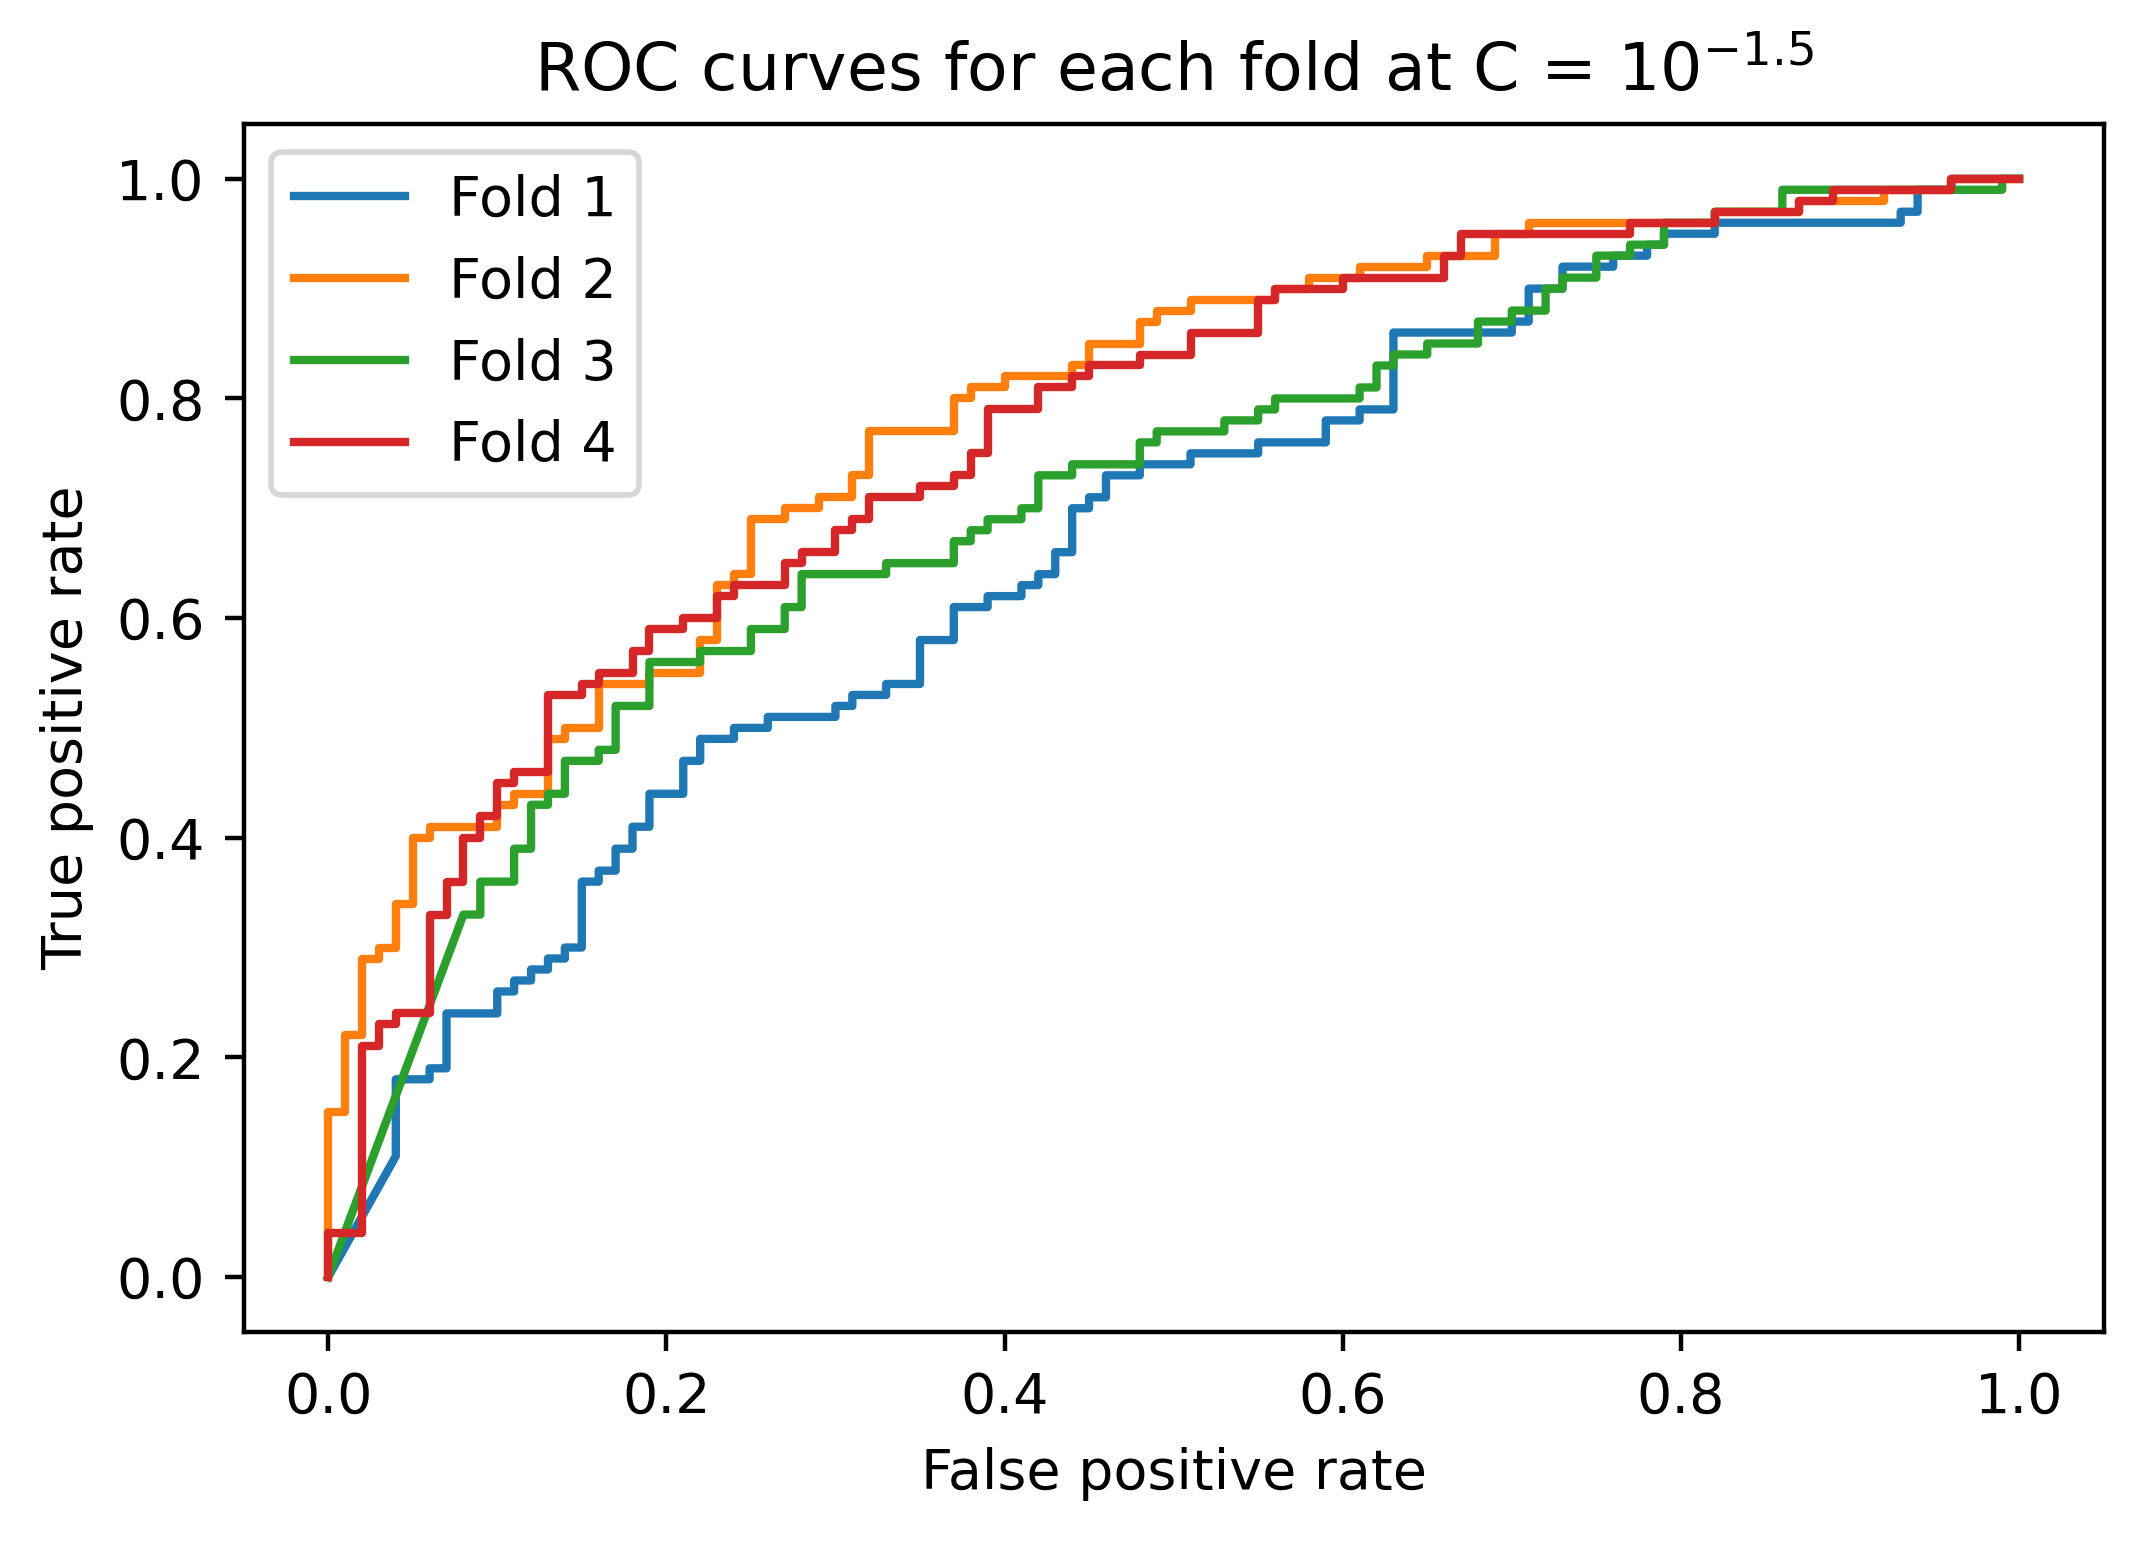

In [49]:
for this_fold in range(k_folds.n_splits):
    fpr = cv_test_roc[best_C_val_ix[0][0]][this_fold][0]
    tpr = cv_test_roc[best_C_val_ix[0][0]][this_fold][1]
    plt.plot(fpr, tpr, label='Fold {}'.format(this_fold+1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves for each fold at C = $10^{-1.5}$')
plt.legend()

Train on all training data with best C value

In [50]:
lr_syn.C = 10**(-1.5)

In [51]:
lr_syn.fit(X_syn_train, y_syn_train)

LogisticRegression(C=0.03162277660168379, penalty='l1', random_state=1,
                   solver='liblinear')

In [52]:
y_syn_train_predict_proba = lr_syn.predict_proba(X_syn_train)

In [53]:
roc_auc_score(y_syn_train, y_syn_train_predict_proba[:,1])

0.8802812499999999

In [54]:
y_syn_test_predict_proba = lr_syn.predict_proba(X_syn_test)

In [55]:
roc_auc_score(y_syn_test, y_syn_test_predict_proba[:,1])

0.8847884788478848

See how many coefficients did not get set to 0

In [56]:
sum((lr_syn.coef_ != 0)[0])

2

In [57]:
lr_syn.intercept_

array([0.])